# Equations of State

## Setup

In [1]:
from matplotlib import colors, cm, colormaps as cmaps, pyplot as plt
import numpy as np

from carpy.physicalchem import eostate, species, fluids, UnreactiveFluidModel, ChemicalSpecies
from carpy.utility import Quantity

In [2]:
# For looping, we'll define an iterable for the equations of state to test
equations_of_state = (
    eostate.IdealGas, eostate.VdW, eostate.RK, eostate.SRK, eostate.SRKmP,
    eostate.PR, eostate.PRmP, eostate.BH2)

In [3]:
# For temperature colouration, use a colour map where the normalised temperature is white
cmap = plt.get_cmap("coolwarm")

def get_colour(x):
    """Get (R, G, B, A) scaled with reduced temperature array, such that T_r=1.0 corresponds to white."""
    y = np.interp(x, (T_rs.min(), 1.0, T_rs.max()), (0, 0.5, 1.0))
    c = cmap(y)
    return c

In the sections that follow, we compare several equations of state.
By plotting the fluid density against temperature and pressure, we should be able to identify the vapour-liquid boundary as a discontinuity in the density map.
Additionally, this boundary will blur at conditions above and beyond the critical point of the substance, i.e. the fluid has achieved supercriticality.

Simplistic equations of state, in general, struggle more with computations for density in the liquid phase than the gaseous phase due to poor modelling of inter-molecular forces.
In light of this, some models "modify" their molar volume predictions using methods from Peneloux or Mathias to correct for this discrepancy.

## Pure Fluid Phase Diagrams

In [4]:
# Data generation options
resolution = 50

# Figure parameters
figwidth = 11
ncols = 3
aspect = 1.6

In [5]:
def plot_species_density(chem_species) -> None:
    """
    Given a pure chemical species, compute the density of the fluid per available equation of state models.

    If a liquid phase is detected, its density is annotated - else the annotation describes vapour density.

    Args:
        chem_species: A chemical species object, describing a pure substance.

    """
    # Pressure and temperature limits are autoscaled w.r.t critical pressure and temperature
    p = Quantity(np.logspace(0, np.round(np.log10(float(chem_species.p_c)) + 0.3)+3, resolution), "Pa")
    T = Quantity(np.linspace(1e-3, (Tmargin := 1.4) * float(chem_species.T_c), resolution), "K")
    pgrid, Tgrid = np.meshgrid(p, T)
    
    # Compute colourmap data
    dens_data = dict()
    dens_poi = dict()
    for i, EOS in enumerate(equations_of_state):
        print(f"\r({i+1}/{len(equations_of_state)}) {EOS.__name__:<20s}", end="")
    
        # Instantiate a model with the given equation of state
        model = UnreactiveFluidModel(eos_class=EOS)
        model.X = {chem_species: 1.0}
    
        # Compute density data
        dens_data[EOS] = model.density(p=pgrid, T=Tgrid)

        # On the 1 atm line, look left for the temperature of the phase boundary and get the density there
        pressure_boil = Quantity(1, "atm")
        temp_to_try = np.linspace(0.90, 1.0, 11) * chem_species.T_boil
        threshold = 3 * model.density(p=pressure_boil, T=chem_species.T_boil)  # Threshold = change of 3x in the density
        dens_to_try = model.density(p=pressure_boil, T=temp_to_try)
        discontinuities = (abs(np.diff(dens_to_try)) > threshold)

        # The index of the discontinuity indicates where the equation of state transitions
        if len(discontinuities) == 0 or not np.any(discontinuities):
            temperature_boil = chem_species.T_boil
            dens_poi[EOS] = model.density(p=pressure_boil, T=temperature_boil)
        else:
            idx = np.where(discontinuities)[0][-1]  # Lowest temperature == highest density == most likely to be liquid
            temperature_boil = temp_to_try[idx]
            dens_poi[EOS] = dens_to_try[idx]
    
    else:
        print(f"\n{'Finished computing':<20s}")

    dens_hi = max([np.percentile(v, 65) for (_, v) in dens_data.items()]) * 1.5
    
    # Create figure
    nrows = int(np.ceil(len(equations_of_state) / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True)
    fig.set_figwidth(figwidth)
    fig.set_figheight((figwidth / aspect) * (nrows / ncols))
    fig.suptitle(f"Equation of State models for Pure {chem_species}", x=0.45, y=0.96)
    
    # Prepare figure-wide colour map
    normaliser = colors.Normalize(0, dens_hi)
    cmap = plt.get_cmap("viridis")
    
    # Compute colourmap data
    for i, EOS in enumerate(equations_of_state):
    
        ax = axs.flat[i]
        ax.set_title(f"`{EOS.__name__}'")
        ax.set_yscale("log")
        ax.set_ylim(p.min(), p.max())
        ax.set_xlabel(f"Temperature [{T.u.mathtext_si}]")
        ax.set_ylabel(f"Pressure [{p.u.mathtext_si}]")
        ax.label_outer()
        ax.axvline(chem_species.T_boil, c="r", alpha=0.4)
        
        # Plot computed data
        ax.pcolormesh(Tgrid, pgrid, dens_data[EOS], norm=normaliser)
        ax.annotate(
            text=f"$\\rho=${float(dens_poi[EOS]):.3f}\n  {dens_poi[EOS].u.mathtext_si}",
            xy=(temperature_boil, pressure_boil),
            xytext=((chem_species.T_boil / (Tmargin * 1.3), Quantity(1, "atm") / 50)),
            va="top",
            arrowprops={"arrowstyle": "-|>", "color": "white", "lw": 2},
            c="white",
        )
        ax.scatter(chem_species.T_c, chem_species.p_c, s=60, marker="x", c="white")
        
    im = cm.ScalarMappable(norm=normaliser, cmap=cmap)
    cbar = fig.colorbar(im, ax=list(axs.flatten()))
    cbar.set_label(f"Density [{dens_data[EOS].u.mathtext_si}]")
    plt.show()

    return None

### Helium

(8/8) BaigangH2           
Finished computing  


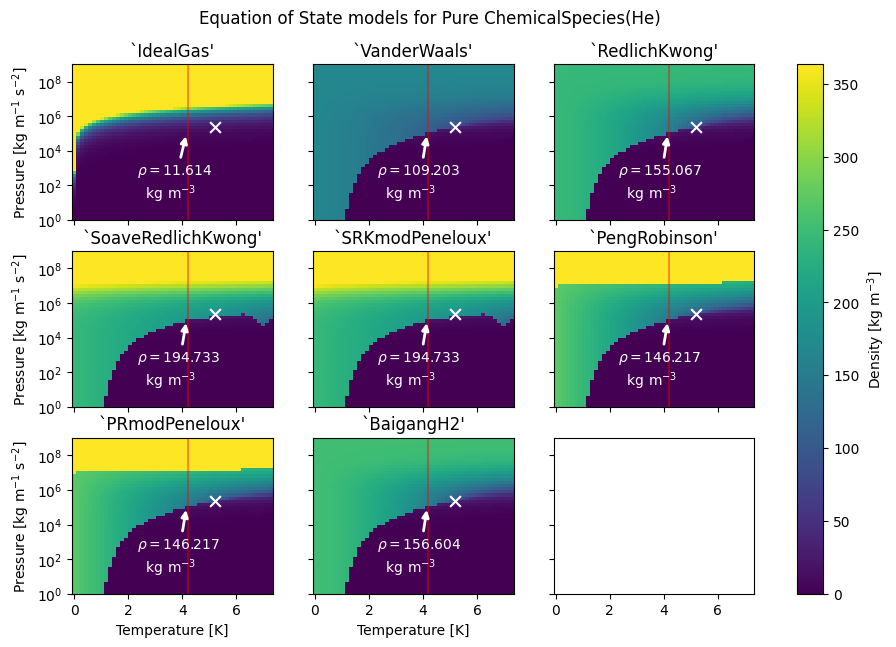

In [6]:
plot_species_density(species.helium())

Liquid helium has a density of about 125 [kg/m3] at the normal boiling condition.

### Hydrogen

(8/8) BaigangH2           
Finished computing  


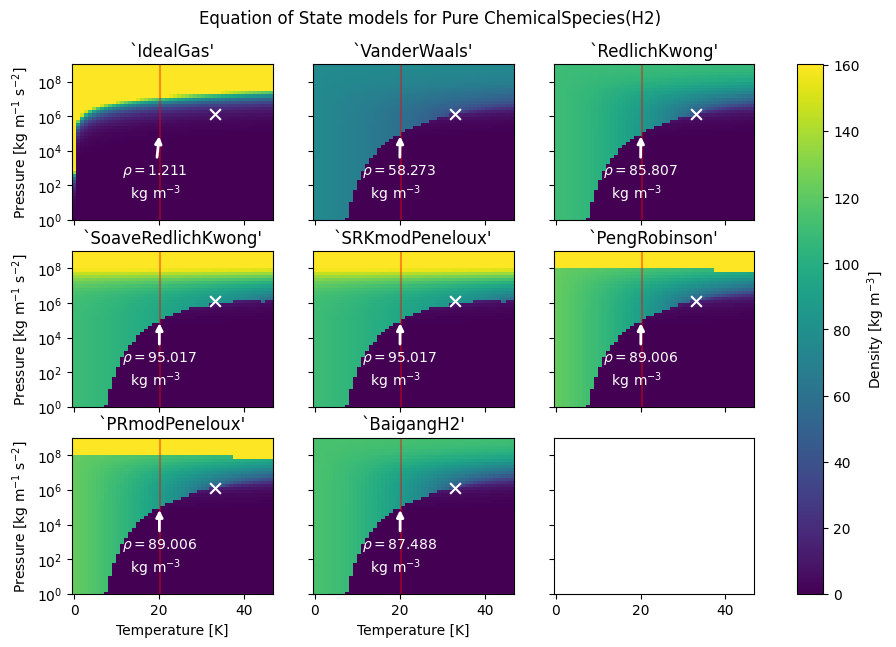

In [7]:
plot_species_density(species.hydrogen())

<div class="alert alert-block alert-info"> <b>📝 Note:</b>
    It is a coincidence that the ideal gas density close to the normal boiling temperature of hydrogen is close to the value of sea-level density of air under standard atmospheric conditions. The ratio of considered temperatures is very close to the molar mass ratios of hydrogen and dry air: $$\frac{288\text{ K}}{20\text{ K}} \approx \frac{29\text{ g/mol}}{2\text{ g/mol}}$$
</div>

Liquid hydrogen has a density of about 71 [kg/m3] at the normal boiling condition.

### Water

(8/8) BaigangH2           
Finished computing  


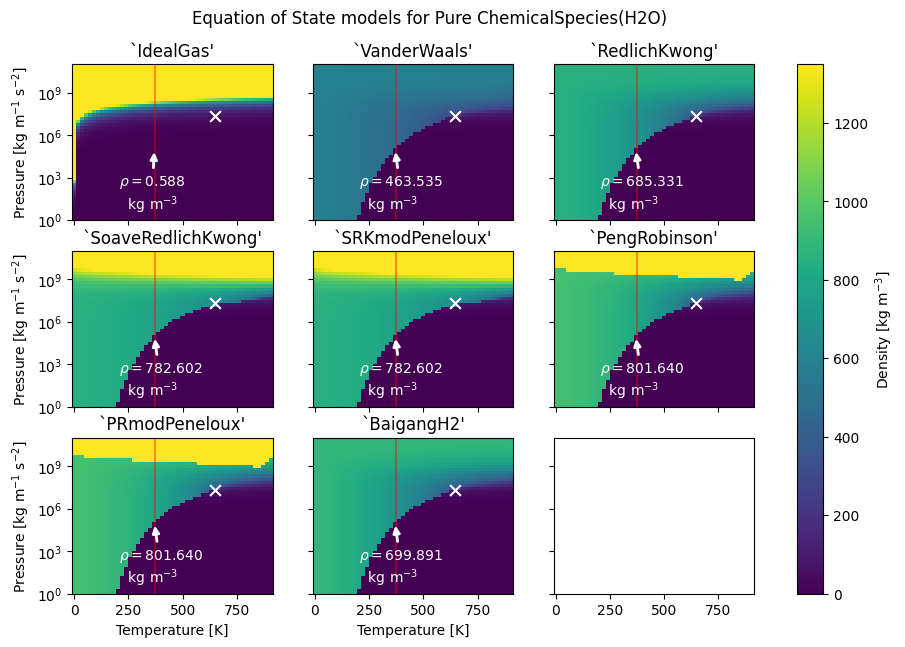

In [8]:
plot_species_density(species.water())

Liquid water has a density of 958 [kg/m3] at the normal boiling condition.

### Nitrogen

(8/8) BaigangH2           
Finished computing  


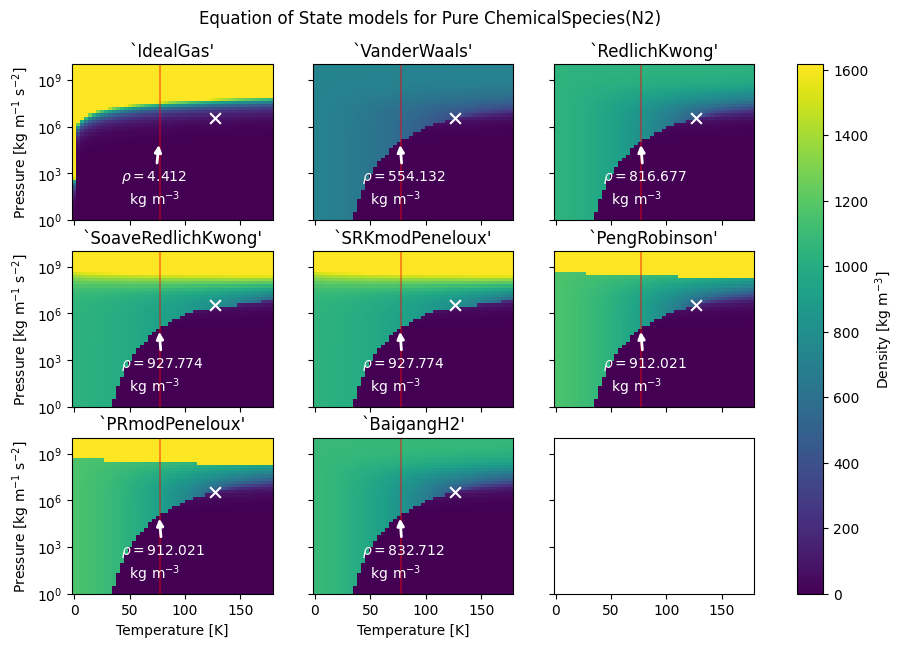

In [9]:
plot_species_density(species.nitrogen())

Liquid nitrogen has a density of about 807 [kg/m3] at the normal boiling condition.

### Methane

(8/8) BaigangH2           
Finished computing  


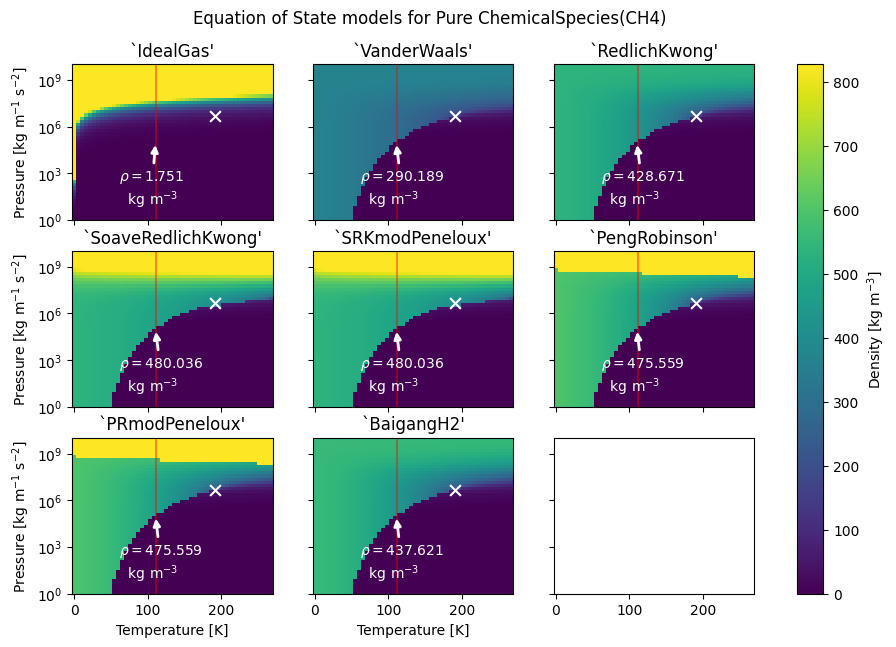

In [10]:
plot_species_density(species.methane())

Liquid methane has a density of about 422.6 [kg/m3] at the normal boiling condition.

## Composite Fluid Phase Diagrams

In [11]:
def plot_fluid_density(fluid_factory) -> None:
    """
    Given a fluid mixture, compute the density of the fluid per available equation of state models.

    If a liquid phase is detected, its density is annotated - else the annotation describes vapour density.

    Args:
        fluid_factory: A function that accepts an Equation of State as an argument, and returns a model of the fluid.

    """
    fluid = fluid_factory()
    
    # Pressure and temperature limits are autoscaled w.r.t critical pressure and temperature
    p = Quantity(np.logspace(0, np.round(np.log10(float(fluid.p_c)) + 0.3)+3, resolution), "Pa")
    T = Quantity(np.linspace(1e-3, (Tmargin := 1.4) * float(fluid.T_c), resolution), "K")
    pgrid, Tgrid = np.meshgrid(p, T)
    
    # Compute colourmap data
    dens_data = dict()
    dens_poi = dict()
    for i, EOS in enumerate(equations_of_state):
        print(f"\r({i+1}/{len(equations_of_state)}) {EOS.__name__:<20s}", end="")
    
        # Instantiate a model with the given equation of state
        model = fluid_factory(eos_class=EOS)
    
        # Compute density data
        dens_data[EOS] = model.density(p=pgrid, T=Tgrid)

        # On the 1 atm line, look left for the temperature of the phase boundary and get the density there
        pressure_boil = Quantity(1, "atm")
        temp_to_try = np.linspace(0.90, 1.0, 11) * model.T_boil
        threshold = 3 * model.density(p=pressure_boil, T=model.T_boil)  # Threshold = change of 3x in the density
        dens_to_try = model.density(p=pressure_boil, T=temp_to_try)
        discontinuities = (abs(np.diff(dens_to_try)) > threshold)

        # The index of the discontinuity indicates where the equation of state transitions
        if len(discontinuities) == 0 or not np.any(discontinuities):
            temperature_boil = model.T_boil
            dens_poi[EOS] = model.density(p=pressure_boil, T=temperature_boil)
        else:
            idx = np.where(discontinuities)[0][-1]  # Lowest temperature == highest density == most likely to be liquid
            temperature_boil = temp_to_try[idx]
            dens_poi[EOS] = dens_to_try[idx]
    
    else:
        print(f"\n{'Finished computing':<20s}")

    dens_hi = max([np.percentile(v, 65) for (_, v) in dens_data.items()]) * 1.5
    
    # Create figure
    nrows = int(np.ceil(len(equations_of_state) / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True)
    fig.set_figwidth(figwidth)
    fig.set_figheight((figwidth / aspect) * (nrows / ncols))
    fig.suptitle(f"Equation of State models for Fluid", x=0.45, y=0.96)
    
    # Prepare figure-wide colour map
    normaliser = colors.Normalize(0, dens_hi)
    cmap = plt.get_cmap("viridis")
    
    # Compute colourmap data
    for i, EOS in enumerate(equations_of_state):
    
        ax = axs.flat[i]
        ax.set_title(f"`{EOS.__name__}'")
        ax.set_yscale("log")
        ax.set_ylim(p.min(), p.max())
        ax.set_xlabel(f"Temperature [{T.u.mathtext_si}]")
        ax.set_ylabel(f"Pressure [{p.u.mathtext_si}]")
        ax.label_outer()
        ax.axvline(model.T_boil, c="r", alpha=0.4)
        
        # Plot computed data
        ax.pcolormesh(Tgrid, pgrid, dens_data[EOS], norm=normaliser)
        ax.annotate(
            text=f"$\\rho=${float(dens_poi[EOS]):.3f}\n  {dens_poi[EOS].u.mathtext_si}",
            xy=(temperature_boil, pressure_boil),
            xytext=((model.T_boil / (Tmargin * 1.3), Quantity(1, "atm") / 50)),
            va="top",
            arrowprops={"arrowstyle": "-|>", "color": "white", "lw": 2},
            c="white",
        )
        ax.scatter(model.T_c, model.p_c, s=60, marker="x", c="white")
        
    im = cm.ScalarMappable(norm=normaliser, cmap=cmap)
    cbar = fig.colorbar(im, ax=list(axs.flatten()))
    cbar.set_label(f"Density [{dens_data[EOS].u.mathtext_si}]")
    plt.show()

    return None

### Jet-A(-3638)

(8/8) BaigangH2           
Finished computing  


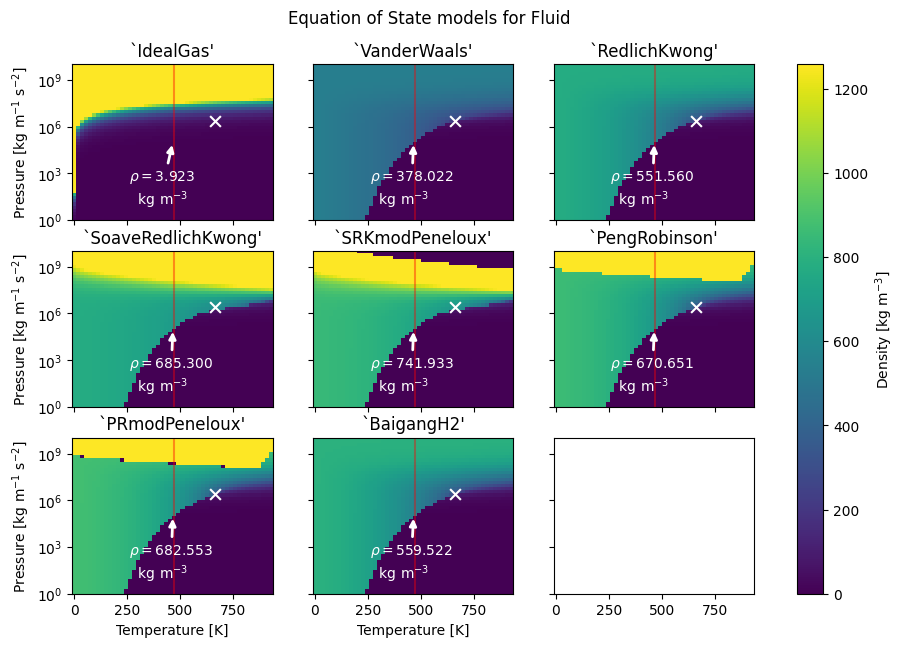

In [12]:
plot_fluid_density(fluids.Jet_A_3638)

### Jet-A(-4658)

(8/8) BaigangH2           
Finished computing  


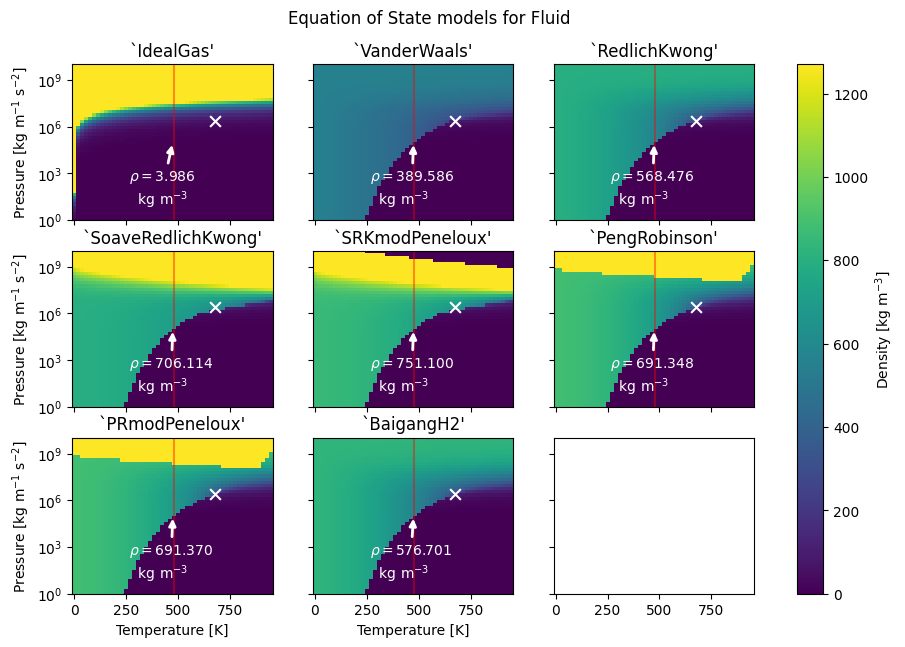

In [13]:
plot_fluid_density(fluids.Jet_A_4658)

### S-8

In [ ]:
plot_fluid_density(fluids.S_8)

(8/8) BaigangH2           